In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pathlib import Path
from glob import glob
import nibabel as nib
from matplotlib import image

In [3]:
NB_DIR = Path.cwd()
DATA_DIR = NB_DIR/'..'/'data'

In [4]:
img_path, mask_path = glob(str(DATA_DIR/'*.nii.gz'))

In [5]:
img_path, mask_path

('/home/sathiesh/machine_learning/BMED360/nbs/../data/kiwi/kiwi_20050217191129_131073_RARE_high_res_axial.nii.gz',
 '/home/sathiesh/machine_learning/BMED360/nbs/../data/kiwi/kiwi_mask.nii.gz')

In [6]:
PROCESSED_IMGS_DIR, PROCESSED_MASKS_DIR = DATA_DIR/'2d_imgs', DATA_DIR/'2d_masks'
PROCESSED_IMGS_DIR.mkdir(exist_ok=True), PROCESSED_MASKS_DIR.mkdir(exist_ok=True);

In [7]:
img, mask = nib.load(img_path).get_fdata(), nib.load(mask_path).get_fdata()

In [8]:
img.shape, mask.shape

((256, 256, 128), (256, 256, 128))

In [9]:
idx = 45

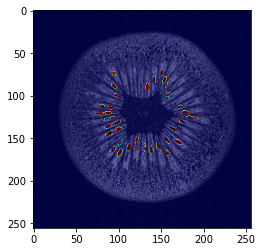

In [10]:
plt.imshow(np.rot90(img[:,:,idx], -1), cmap='gray')
plt.imshow(np.rot90(mask[:,:,idx], -1), cmap='jet', alpha=0.5)
plt.show()

In [12]:
def nii2png(data, range_val, save_dir, is_mask=False): 
    annotated_idxs = []
    for i in range(range_val):
        if len(np.unique(data[:,:,i])) != 1 and is_mask: annotated_idxs.append(i)
        image.imsave(f'{save_dir}/slice_{i}.png', data[:,:,i], cmap='gray')
    return annotated_idxs

In [13]:
nii2png(data=img, range_val=img.shape[2], save_dir=PROCESSED_IMGS_DIR)

[]

In [14]:
range_val=46 #manually segmented the first 46 slices  
annotated_idxs = nii2png(data=mask, range_val=range_val, save_dir=PROCESSED_MASKS_DIR, is_mask=True) 

In [15]:
len(annotated_idxs)

27

### Create dataframe

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
_, valid_idxs = train_test_split(annotated_idxs, test_size=0.2, shuffle=True, random_state=37)

In [18]:
mask_list = sorted(glob(str(PROCESSED_MASKS_DIR/'*')))
img_list = [fn.replace('masks', 'imgs')for fn in mask_list]
slice_id = [int(fn.split('_')[-1].split('.')[0] )for fn in mask_list]

In [19]:
test_img_list = sorted(glob(str(PROCESSED_IMGS_DIR/'*')))

In [20]:
test_img_list = [fn for fn in test_img_list if fn not in img_list] #remove files with masks

In [21]:
len(mask_list), len(img_list), len(test_img_list)

(46, 46, 82)

In [22]:
data = {'img_path': img_list, 'mask_path': mask_list, 'slice_id': slice_id, 'is_valid':False}
df_train = pd.DataFrame(data)

In [23]:
df_train.loc[df_train.slice_id.isin(valid_idxs), 'is_valid'] = True

In [24]:
data = {'img_path': test_img_list}
df_test = pd.DataFrame(data)

In [25]:
CSV_DIR = DATA_DIR/'csv'
CSV_DIR.mkdir(exist_ok=True)

In [26]:
df_train.to_csv(CSV_DIR/'train_data.csv', index=False)
df_test.to_csv(CSV_DIR/'test_data.csv', index=False)